In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import bambi as bmb
import arviz as az

from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler

plt.rc('font', **{'size': 20})

In [2]:
def add_day_columns(df, timestamp_col, participant_df):
    return add_rel_day(add_start_day(add_day(df, timestamp_col), participant_df))

def add_day(df, timestamp_col):
    df = df.copy()
    df["Day"] = (df[timestamp_col]/(60*60*24)).apply(np.floor)
    return df

def add_start_day(df, participant_df):
    participant_df = participant_df.copy()
    participant_df["StartDay"] = (participant_df["DataStartStampUtc"]/(60*60*24)).apply(np.floor)
    return pd.merge(df, participant_df[['ParticipantId',"StartDay"]])

def add_rel_day(df):
    df = df.copy()
    df["RelDay"] = df["Day"]-df["StartDay"]
    return df

def scale(df, group_col, scale_col, scaler, postfix):
    for gid in set(df[group_col]):
        df.loc[df[group_col]==gid,[scale_col+postfix]] = scaler.fit_transform(df.loc[df[group_col]==gid,[scale_col]])

def get_trimmed_pids(df):
    df = df.copy()
    df = df[~df["Phone ER Interest"].isna()]
    df = df.groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    df = df.groupby(['ParticipantId']).size().reset_index(drop=False).rename(columns={0:"Count"})
    return df.loc[df.Count < 4,'ParticipantId'].tolist()

def sample_and_mean(x):
    return lambda g: g.mean() if g.shape[0] < x else g.sample(x).mean()

def largest_and_mean(x):
    return lambda g: g.nlargest(x).mean()

def smallest_and_mean(x):
    return lambda g: g.nsmallest(x).mean()

In [8]:
runs_df = pd.read_csv('../data/Runs.csv')
states_df = pd.read_csv('../data/States.csv')
emotions_df = pd.read_csv('../data/Emotions.csv')
participant_df = pd.read_csv('../data/Participants.csv')

emotions_df = emotions_df[emotions_df["WatchDataQuality"] == "Good"]

emotions_df["ER Interest"] = pd.to_numeric(emotions_df["ER Interest"], errors='coerce')
emotions_df["Phone ER Interest"] = pd.to_numeric(emotions_df["Phone ER Interest"], errors='coerce')
emotions_df["Response Time (min)"] = (emotions_df["SubmissionTimestampUtc"] - emotions_df["DeliveredTimestampUtc"])/60

runs_df = add_day_columns(runs_df, "DeliveredTimestampUtc", participant_df)
states_df = add_day_columns(states_df, "TimestampUtc", participant_df)
emotions_df = add_day_columns(emotions_df, "OpenedTimestampUtc", participant_df)

to_trim = get_trimmed_pids(emotions_df)

runs_df = runs_df[~runs_df["ParticipantId"].isin(to_trim)]
states_df = states_df[~states_df["ParticipantId"].isin(to_trim)]
emotions_df = emotions_df[~emotions_df["ParticipantId"].isin(to_trim)]

runs_df = runs_df[runs_df["RelDay"] < 11]
states_df = states_df[states_df["RelDay"] < 11]
emotions_df = emotions_df[emotions_df["RelDay"] < 11]

warnings.filterwarnings("ignore", category=UserWarning)
scale(emotions_df, "ParticipantId", "Phone ER Interest", QuantileTransformer(n_quantiles=40), " (quant)")
scale(emotions_df, "ParticipantId", "Phone ER Interest", RobustScaler(), " (robust)")
scale(emotions_df, "ParticipantId", "Phone ER Interest", MinMaxScaler(), " (minmax)")
warnings.resetwarnings()

emotions_df.shape

(3650, 27)

In [3]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    df["ER Interest (num)"] = pd.to_numeric(df["ER Interest"], errors='coerce')
    df["Phone ER Interest (num)"] = pd.to_numeric(df["Phone ER Interest"], errors='coerce')
    df = df[["ER Interest (num)","ER Interest", "Phone ER Interest (num)","Phone ER Interest"]]
    print("All NA values are due to hyphens in the csv")
    print(((df["Phone ER Interest (num)"].isna() & (df["Phone ER Interest"] != "-")) | ((df["ER Interest (num)"].isna()) & (df["ER Interest"] != "-"))).sum())
local()

All NA values are due to hyphens in the csv
0


In [185]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    print("Almost all na values are due to an anxiety level of 1")
    print((((df["Phone ER Interest"] == "-") & (df["State Anxiety"]!=1))).sum())
local()

Almost all na values are due to an anxiety level of 1
2


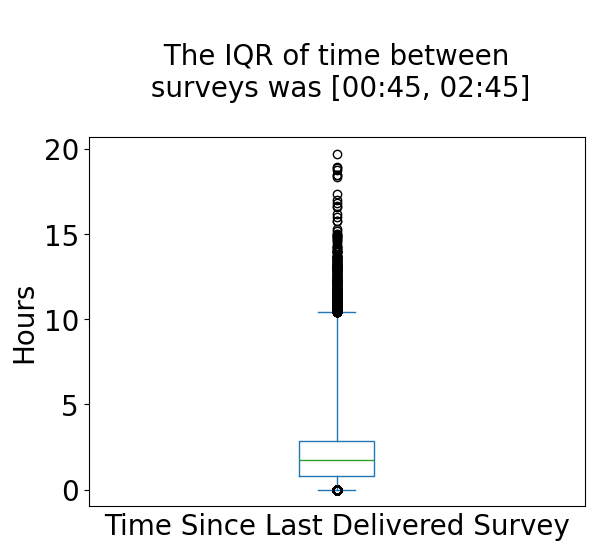

array([0.81, 2.87])

In [6]:
def local():
    deliveries = runs_df.sort_values(["ParticipantId","DeliveredTimestamp"]).reset_index(drop=True)
    diff = deliveries.groupby(["ParticipantId","RelDay"])["DeliveredTimestamp"].diff()
    (diff / (60*60)).plot.box(ylabel='Hours', whis=[5,95])
    plt.title("\n The IQR of time between \n surveys was [00:45, 02:45]\n", fontdict={"size":20})
    plt.xticks([])
    plt.xlabel("Time Since Last Delivered Survey")
    plt.show()
    return (np.nanpercentile(diff.tolist(),[25,75])/(60*60)).round(2)
local()

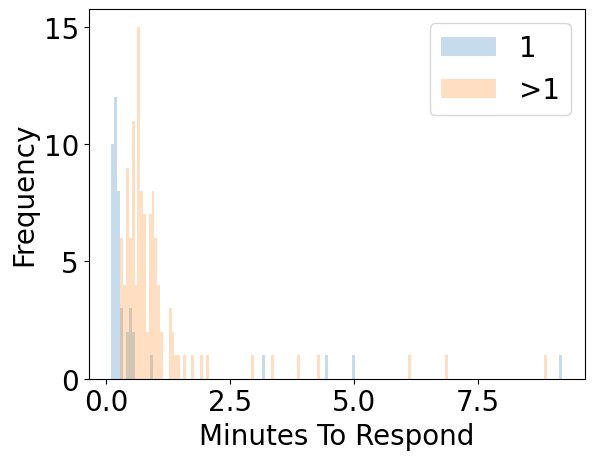

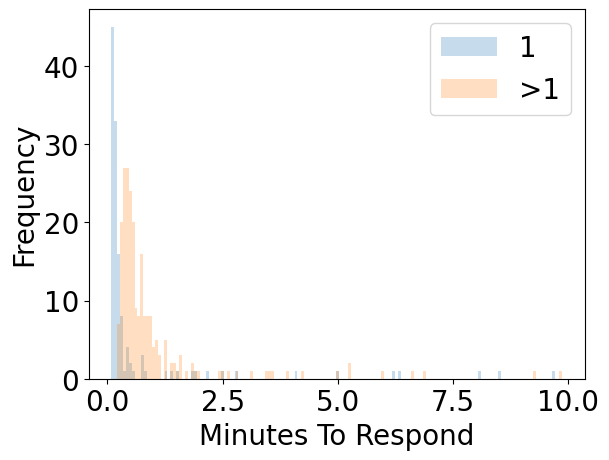

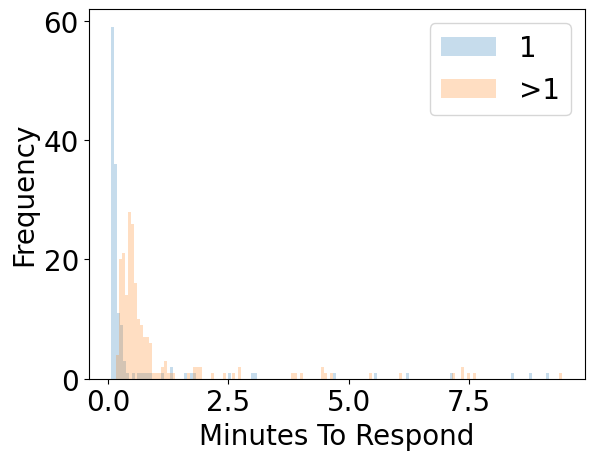

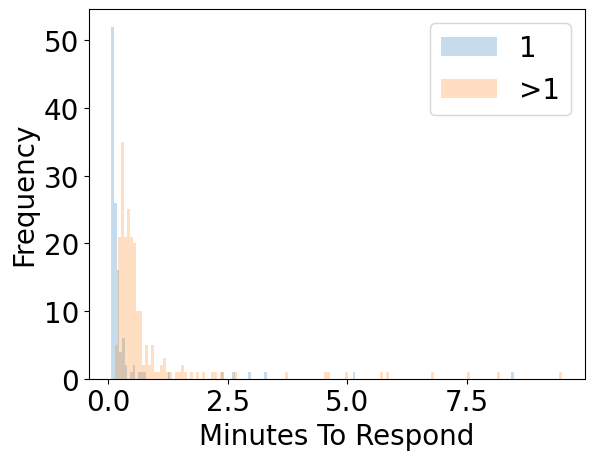

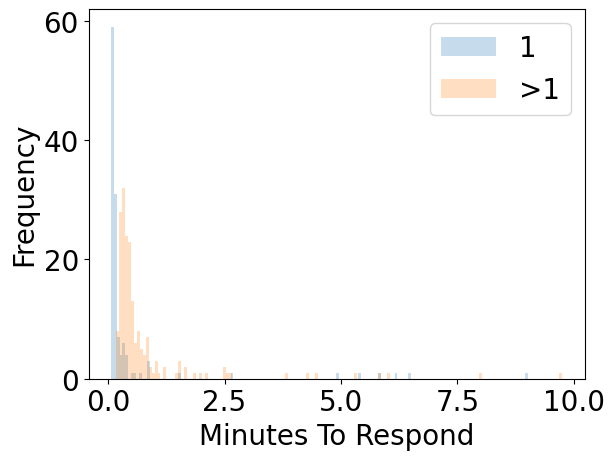

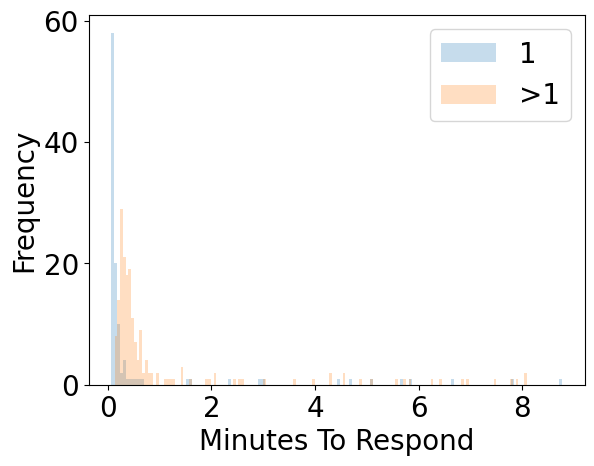

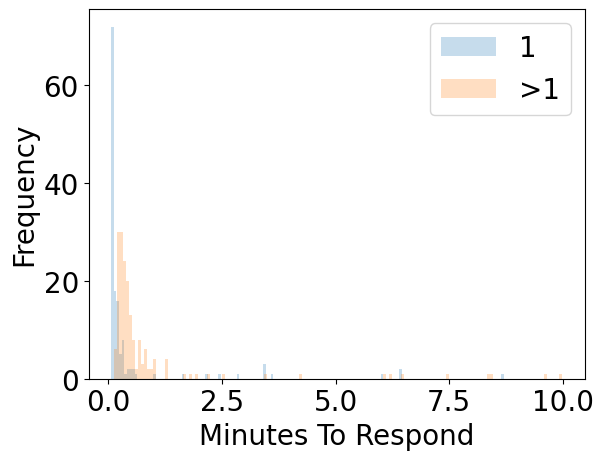

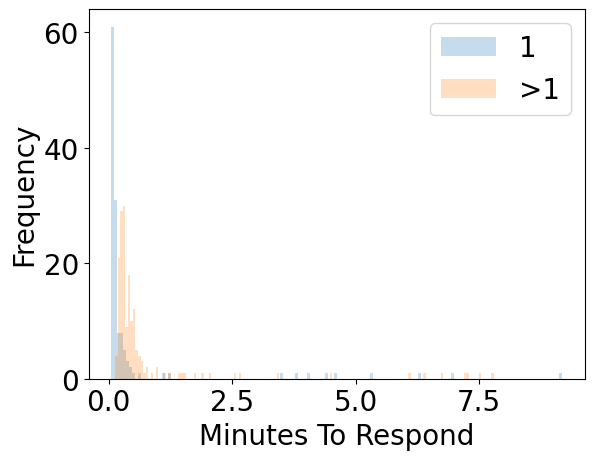

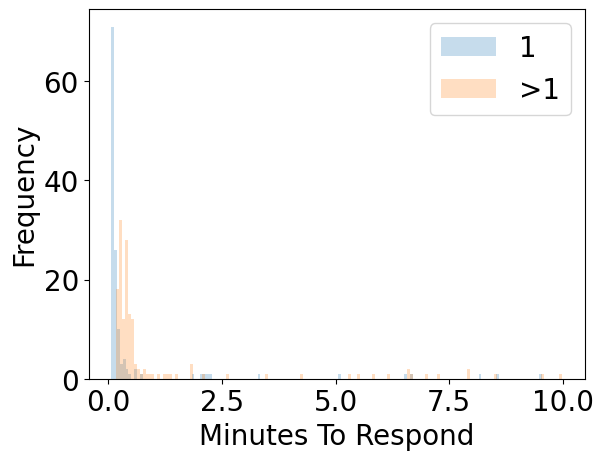

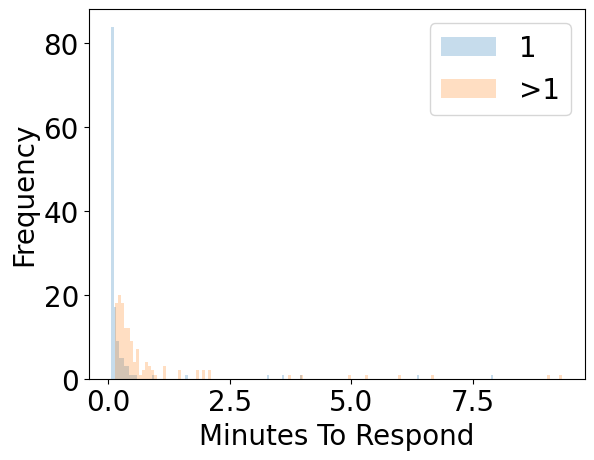

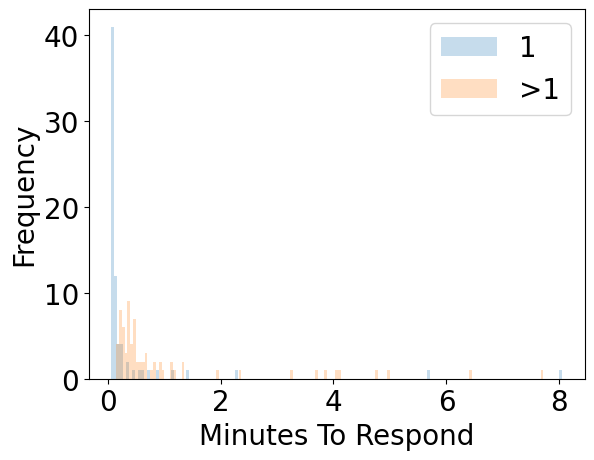

58.96

In [24]:
for i in emotions_df["RelDay"].unique():
    
    emotions_df[(emotions_df["Phone ER Interest"].isna()) & (emotions_df["RelDay"] == i) & (emotions_df["Response Time (min)"] < 10)]["Response Time (min)"].plot(kind="hist",bins=150,label="1",alpha=.25)
    emotions_df[(~emotions_df["Phone ER Interest"].isna()) & (emotions_df["RelDay"] == i) & (emotions_df["Response Time (min)"] < 10)]["Response Time (min)"].plot(kind="hist",bins=150,label=">1",alpha=.25)
    #plt.title("\n78.69% of all responses\noccured in 2 minutes or less\n")
    #plt.yticks([1000,2000],["1k","2k"])
    plt.xlabel("Minutes To Respond")
    plt.legend()
    plt.show()
round((emotions_df["Response Time (min)"] < .5).sum()/emotions_df.shape[0],4)*100

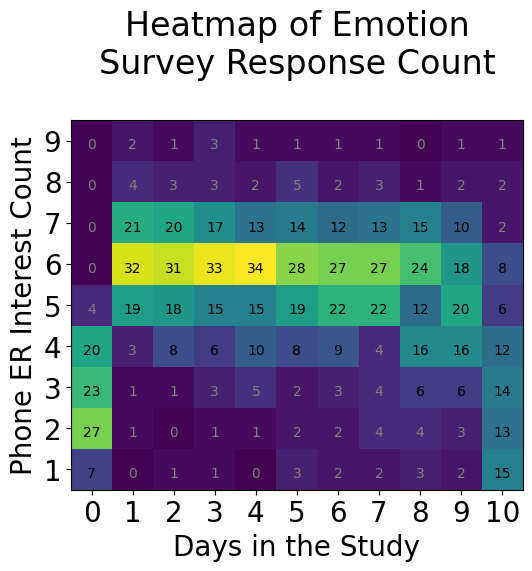

In [187]:
def local():
    df = pd.read_csv('../data/Emotions.csv')
    df = add_day_columns(df, "OpenedTimestamp", participant_df)
    to_trim = get_trimmed_pids(df)
    df = df[~df["ParticipantId"].isin(to_trim)]
    df = df[df["RelDay"] < 11]
    df = df[~df["Phone ER Interest"].isna()]
    df = df.groupby(["ParticipantId","RelDay"]).size().reset_index().rename(columns={0:"Count"})
    
    heatmap = np.histogram2d(df["RelDay"], df["Count"], bins=[11,9])[0]
    extent = (0, 11, 1, 10)
    plt.title("Heatmap of Emotion\nSurvey Response Count\n")
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            plt.gca().text(.5+i, 1.4+j, str(int(heatmap[i, j])), ha="center", va="center", color="black" if heatmap[i, j] >= 6 else "gray", fontdict={"size":10})
    plt.yticks([x+1.5 for x in range(9)],[str(x+1) for x in range(9)])
    plt.xticks([x+0.5 for x in range(11)],[str(x) for x in range(11)])
    plt.ylabel("Phone ER Interest Count")
    plt.xlabel("Days in the Study")
    plt.show()
local()

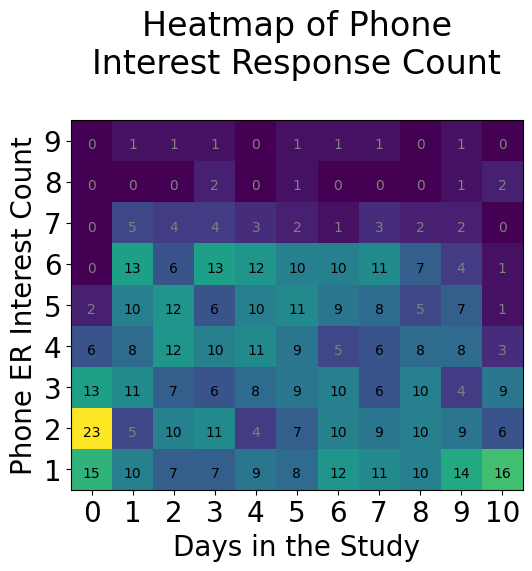

In [188]:
def local():
    
    df = emotions_df[~emotions_df["Phone ER Interest"].isna()].groupby(["ParticipantId","RelDay"]).size().reset_index().rename(columns={0:"Count"})
    heatmap = np.histogram2d(df["RelDay"], df["Count"], bins=[11,9])[0]
    extent = (0, 11, 1, 10)
    plt.title("Heatmap of Phone\nInterest Response Count\n")
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            plt.gca().text(.5+i, 1.4+j, str(int(heatmap[i, j])), ha="center", va="center", color="black" if heatmap[i, j] >= 6 else "gray", fontdict={"size":10})
    plt.yticks([x+0.5 for x in range(1,10)],[str(x) for x in range(1,10)])
    plt.xticks([x+0.5 for x in range(0,11)],[str(x) for x in range(0,11)])
    plt.ylabel("Phone ER Interest Count")
    plt.xlabel("Days in the Study")
    plt.show()
local()

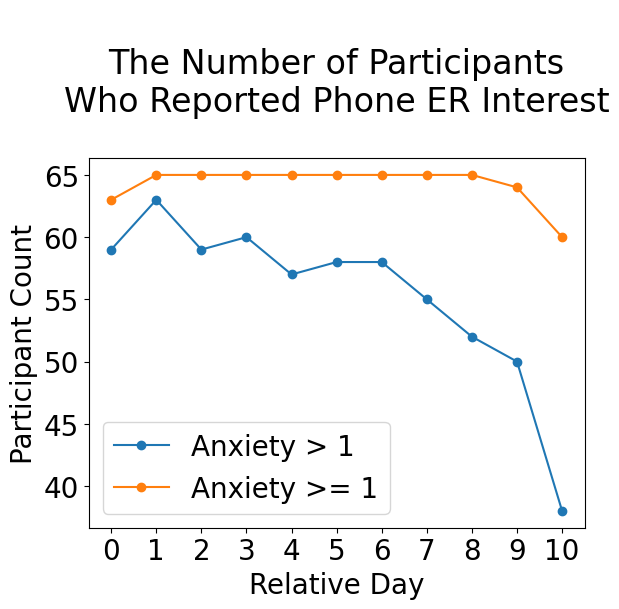

In [6]:
def local():
    groups = emotions_df[~emotions_df["Phone ER Interest"].isna()].groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups = groups.groupby(["RelDay"]).size()
    groups.plot(marker="o",label='Anxiety > 1')

    groups = emotions_df.groupby(["ParticipantId","RelDay"]).size().reset_index(drop=False)
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups = groups.groupby(["RelDay"]).size()
    groups.plot(marker="o",label='Anxiety >= 1')

    plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
    plt.xlabel("Relative Day")
    plt.ylabel("Participant Count")
    plt.title("\nThe Number of Participants\nWho Reported Phone ER Interest\n")
    plt.legend()

local()

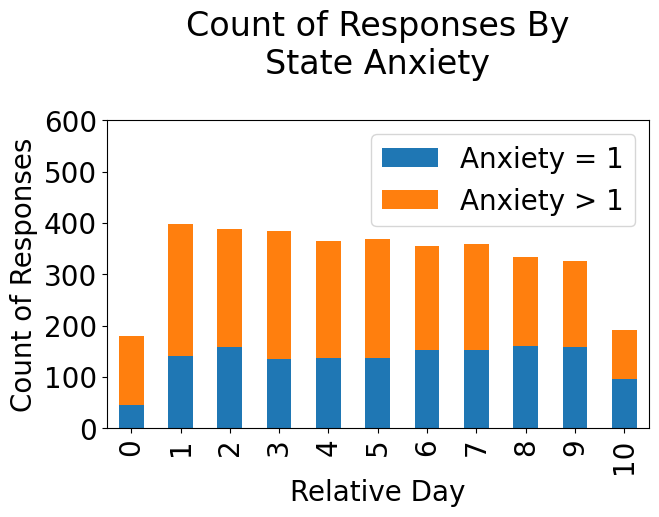

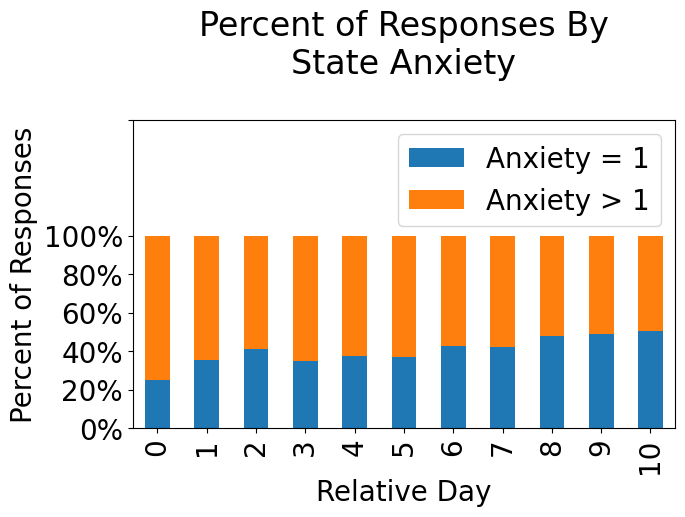

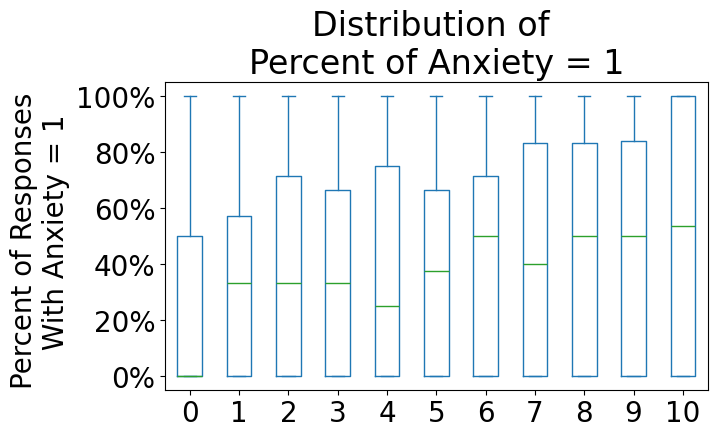

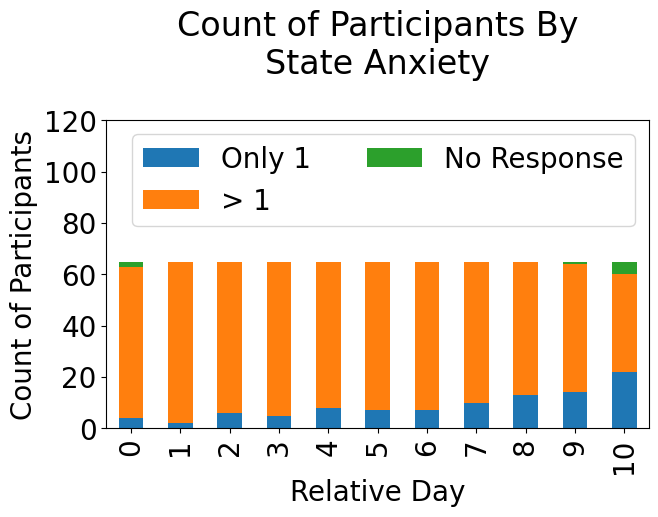

In [162]:
def local():
    anxiety_eq_1_count = emotions_df[emotions_df["State Anxiety"]==1].groupby(["RelDay"]).size()
    anxiety_gt_1_count = emotions_df[emotions_df["State Anxiety"]> 1].groupby(["RelDay"]).size()
    anxiety_ge_1_count = emotions_df[emotions_df["State Anxiety"]>=1].groupby(["RelDay"]).size()

    df = pd.concat([anxiety_eq_1_count,anxiety_gt_1_count],axis=1)
    df = df.rename(columns={0:"Anxiety = 1",1:"Anxiety > 1"})
    df.plot(kind="bar",stacked=True, figsize=(7,4))
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0,100,200,300,400,500,600])
    plt.xlabel("Relative Day")
    plt.ylabel("Count of Responses")
    plt.title("Count of Responses By\nState Anxiety\n")
    plt.legend()
    plt.show()

    df = pd.concat([anxiety_eq_1_count/anxiety_ge_1_count,anxiety_gt_1_count/anxiety_ge_1_count],axis=1)
    df = df.rename(columns={0:"Anxiety = 1",1:"Anxiety > 1"})
    df.plot(kind="bar",stacked=True, figsize=(7,4))
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0,1.6],["0%","20%","40%","60%","80%","100%",""])
    plt.xlabel("Relative Day")
    plt.ylabel("Percent of Responses")
    plt.title("Percent of Responses By\nState Anxiety\n")
    plt.legend()
    plt.show()

    p_anxiety_eq_1_count = emotions_df[emotions_df["State Anxiety"]==1].groupby(["RelDay","ParticipantId"]).size()
    p_anxiety_gt_1_count = emotions_df[emotions_df["State Anxiety"]> 1].groupby(["RelDay","ParticipantId"]).size()
    p_anxiety_ge_1_count = emotions_df[emotions_df["State Anxiety"]>=1].groupby(["RelDay","ParticipantId"]).size()

    df = pd.concat([p_anxiety_eq_1_count,p_anxiety_ge_1_count],axis=1).fillna(0)
    participant_count = df.index.get_level_values("ParticipantId").unique().shape

    (df[0]/df[1]).reset_index(drop=False)[["RelDay",0]].plot.box(by="RelDay", figsize=(7,4))
    plt.title("Distribution of \nPercent of Anxiety = 1")
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],["0%","20%","40%","60%","80%","100%"])
    plt.ylabel("Percent of Responses \n With Anxiety = 1")
    plt.show()

    eq_1_count = (df[0] == df[1]).groupby("RelDay").sum()
    ne_1_count = (df[0] != df[1]).groupby("RelDay").sum()
    none_count = participant_count-df[[1]].groupby("RelDay").size()

    df = pd.concat([eq_1_count,ne_1_count,none_count],axis=1)
    df = df.rename(columns={0:"Only 1",1:"> 1", 2:"No Response"})
    df.plot(kind="bar",stacked=True, figsize=(7,4))
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0","1","2","3","4","5","6","7","8","9","10"])
    plt.yticks([0,20,40,60,80,100,120],["0","20","40","60","80","100","120"])
    plt.xlabel("Relative Day")
    plt.ylabel("Count of Participants")
    plt.title("Count of Participants By\nState Anxiety\n")

    plt.legend(ncols=2)
    plt.show()
    

local()

### ~88% of delivered Current Emotions Surveys Were Responded To

In [126]:
def local():
    emotions_df = runs_df[runs_df["ScriptName"] == "Current Emotions Survey"]
    return round(emotions_df["Submitted"].sum()/emotions_df.shape[0],4)*100
local()

88.42

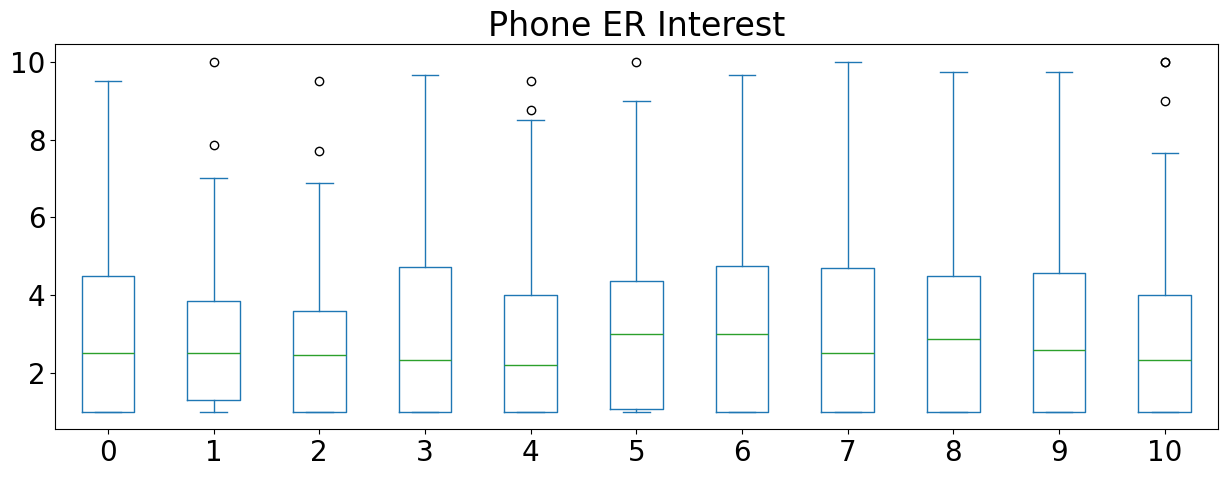

In [127]:
def local():
    col    = "Phone ER Interest"
    groups = emotions_df.groupby(["ParticipantId","RelDay"])[col].mean().reset_index(drop=False)
    groups = groups[["RelDay",col]]
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups[["RelDay",col]].plot.box(by="RelDay",figsize=(15,5))
    plt.show()
local()

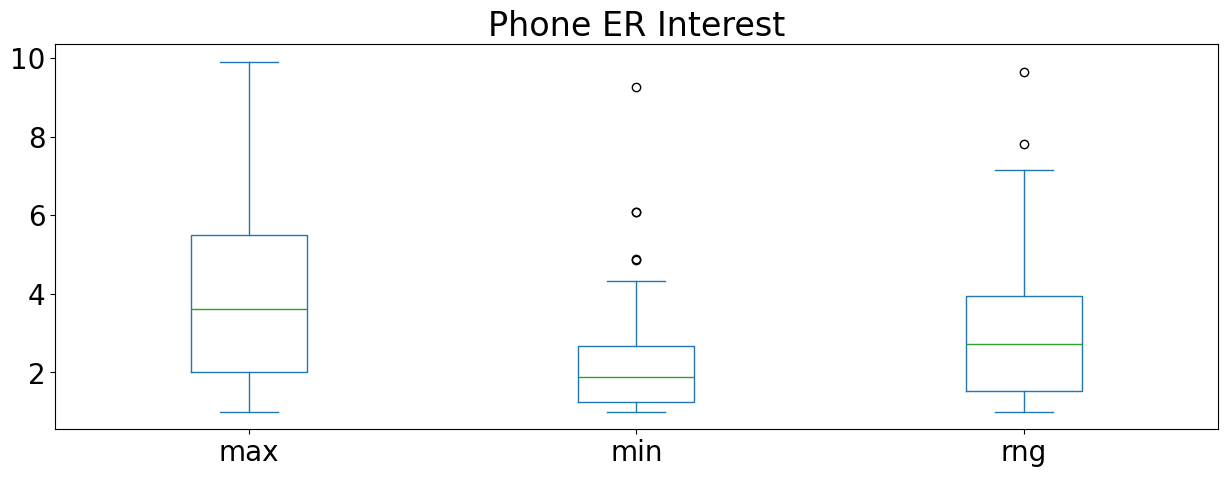

In [165]:
def local():
    col    = "Phone ER Interest"
    df = emotions_df.copy()
    max_means = df.groupby(["ParticipantId","RelDay"])[col].max().reset_index(drop=False)
    max_means = max_means.groupby(["ParticipantId"])[col].mean().reset_index(drop=False)
    rng_means = df.groupby(["ParticipantId"])[col].mean().reset_index(drop=False)
    min_means = df.groupby(["ParticipantId","RelDay"])[col].min().reset_index(drop=False)
    min_means = min_means.groupby(["ParticipantId"])[col].mean().reset_index(drop=False)

    max_means["type"] = "max"
    rng_means["type"] = "rng"
    min_means["type"] = "min"

    all_means = pd.concat([max_means,rng_means,min_means],axis=0)
    all_means[["type",col]].plot.box(by="type",figsize=(15,5))

    plt.xticks([1,2,3])

local()

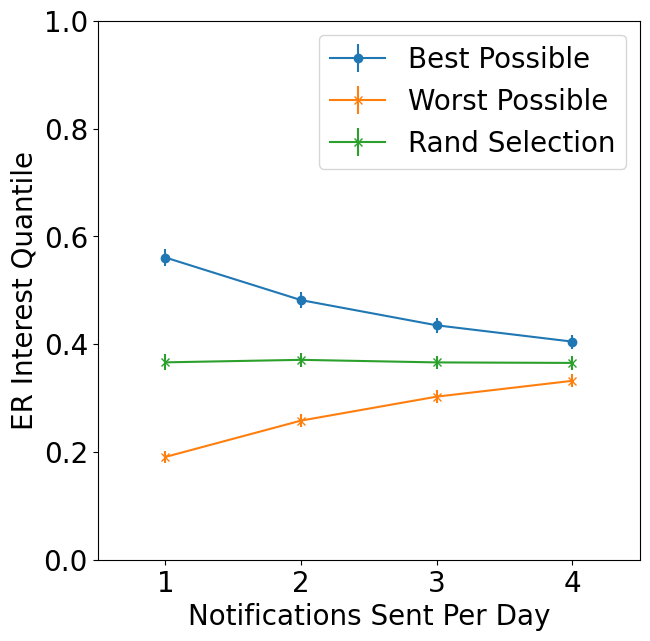

In [238]:
def local():
    groups = emotions_df.groupby(["ParticipantId","RelDay"])["Phone ER Interest (quant)"]

    #Best
    best_y = lambda x: groups.apply(largest_and_mean(x)).tolist()

    #Worst
    worst_y = lambda x: groups.apply(smallest_and_mean(x)).tolist()

    #rand
    rand_y = lambda x: groups.apply(sample_and_mean(x)).tolist()

    xs = [1,2,3,4]

    best_ys = list(map(best_y,xs))
    worst_ys = list(map(worst_y,xs))
    rand_ys = list(map(rand_y,xs))

    ys  = lambda Ys: list(map(np.mean,Ys))
    var = lambda Ys: [ np.var(ys) for ys in Ys]
    sd  = lambda Ys: [ np.std(ys) for ys in Ys]
    se  = lambda Ys: [ np.std(ys)/np.sqrt(len(ys)) for ys in Ys]
    hi  = lambda Ys: [ np.percentile(ys,65)-np.median(ys) for ys in Ys]
    lo  = lambda Ys: [ np.median(ys)-np.percentile(ys,35) for ys in Ys]

    #yerr=[lo(best_ys),hi(best_ys)]

    plt.figure(figsize=(7,7))

    plt.errorbar(xs,ys(best_ys), se(best_ys), marker='o', label="Best Possible")
    plt.errorbar(xs,ys(worst_ys), se(worst_ys), marker='x', label="Worst Possible")
    plt.errorbar(xs,ys(rand_ys), se(rand_ys), marker='x', label="Rand Selection")

    plt.xlim(.5,4.5)
    plt.ylim(0,1)
    plt.legend(loc='upper right')
    plt.ylabel("ER Interest Quantile")
    plt.xlabel("Notifications Sent Per Day")
local()

In [ ]:
def local():
    col    = "Phone ER Interest"
    groups = emotions_df.groupby(["ParticipantId","RelDay"])[col].mean().reset_index(drop=False)
    groups = groups[["RelDay",col]]
    groups[["RelDay"]] = groups[["RelDay"]].astype(int)
    groups[["RelDay",col]].plot.box(by="RelDay",figsize=(15,7))
    plt.show()
local()

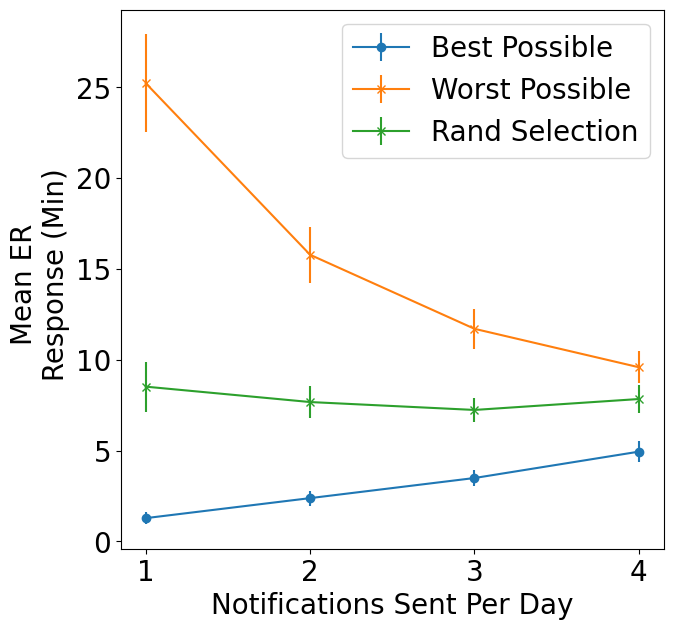

In [65]:
def local():
    groups = emotions_df.groupby(["ParticipantId","RelDay"])["Response Time (min)"]

    #Best
    best_y = lambda x: groups.apply(smallest_and_mean(x)).tolist()

    #Worst
    worst_y = lambda x: groups.apply(largest_and_mean(x)).tolist()

    #rand
    rand_y = lambda x: groups.apply(sample_and_mean(x)).tolist()

    xs = [1,2,3,4]

    best_ys = list(map(best_y,xs))
    worst_ys = list(map(worst_y,xs))
    rand_ys = list(map(rand_y,xs))

    ys  = lambda Ys: list(map(np.mean,Ys))
    var = lambda Ys: [ np.var(ys) for ys in Ys]
    sd  = lambda Ys: [ np.std(ys) for ys in Ys]
    se  = lambda Ys: [ np.std(ys)/np.sqrt(len(ys)) for ys in Ys]
    hi  = lambda Ys: [ np.percentile(ys,65)-np.median(ys) for ys in Ys]
    lo  = lambda Ys: [ np.median(ys)-np.percentile(ys,35) for ys in Ys]

    #yerr=[lo(best_ys),hi(best_ys)]

    plt.figure(figsize=(7,7))

    plt.errorbar(xs,ys(best_ys), se(best_ys), marker='o', label="Best Possible")
    plt.errorbar(xs,ys(worst_ys), se(worst_ys), marker='x', label="Worst Possible")
    plt.errorbar(xs,ys(rand_ys), se(rand_ys), marker='x', label="Rand Selection")

    #plt.xlim(.5,4.5)
    #plt.ylim(1,5)
    plt.legend(loc='upper right')
    plt.ylabel("Mean ER \n Response (Min)")
    plt.xlabel("Notifications Sent Per Day")
local()

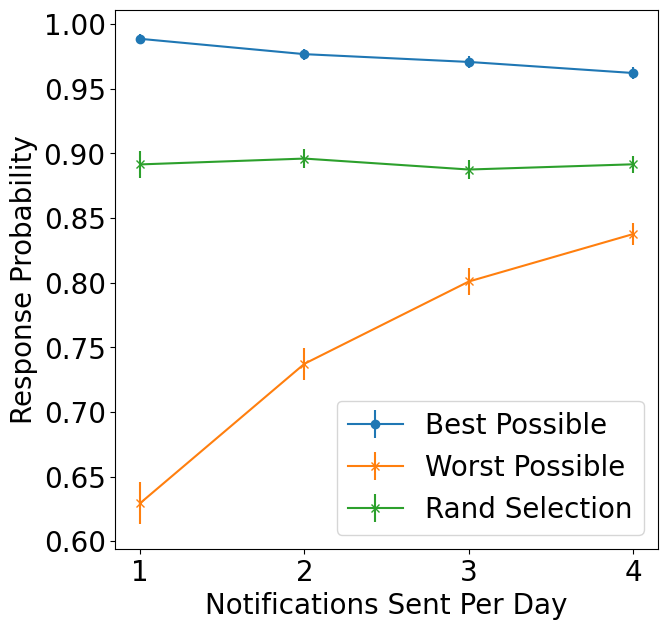

In [244]:
def local():
    
    emotion_runs = runs_df[runs_df["ScriptName"] == "Current Emotions Survey"]

    groups = emotion_runs.groupby(["ParticipantId","RelDay"])["Submitted"]

    #Best
    best_y = lambda x: groups.apply(largest_and_mean(x)).tolist()

    #Worst
    worst_y = lambda x: groups.apply(smallest_and_mean(x)).tolist()

    #rand
    rand_y = lambda x: groups.apply(sample_and_mean(x)).tolist()

    xs = [1,2,3,4]

    best_ys = list(map(best_y,xs))
    worst_ys = list(map(worst_y,xs))
    rand_ys = list(map(rand_y,xs))

    ys  = lambda Ys: list(map(np.mean,Ys))
    var = lambda Ys: [ np.var(ys) for ys in Ys]
    sd  = lambda Ys: [ np.std(ys) for ys in Ys]
    se  = lambda Ys: [ np.std(ys)/np.sqrt(len(ys)) for ys in Ys]
    hi  = lambda Ys: [ np.percentile(ys,65)-np.median(ys) for ys in Ys]
    lo  = lambda Ys: [ np.median(ys)-np.percentile(ys,35) for ys in Ys]

    #yerr=[lo(best_ys),hi(best_ys)]

    plt.figure(figsize=(7,7))

    plt.errorbar(xs,ys(best_ys), se(best_ys), marker='o', label="Best Possible")
    plt.errorbar(xs,ys(worst_ys), se(worst_ys), marker='x', label="Worst Possible")
    plt.errorbar(xs,ys(rand_ys), se(rand_ys), marker='x', label="Rand Selection")

    #plt.xlim(.5,4.5)
    #plt.ylim(1,5)
    plt.legend(loc='lower right')
    plt.ylabel("Response Probability")
    plt.xlabel("Notifications Sent Per Day")
local()

## ER Interest to Phone ER Interest

There appear to be two distinct relationships between Phone ER Interest and ER Interest.

This can be seen clearly in the Heatmap with the diagonal line to the top right

The low Phone ER Interest response does not seem to be related to specific individuals. We can see this looking at the second regression plot below. If it was a collection of individuals we'd see their slopes consistently below 0.1. 

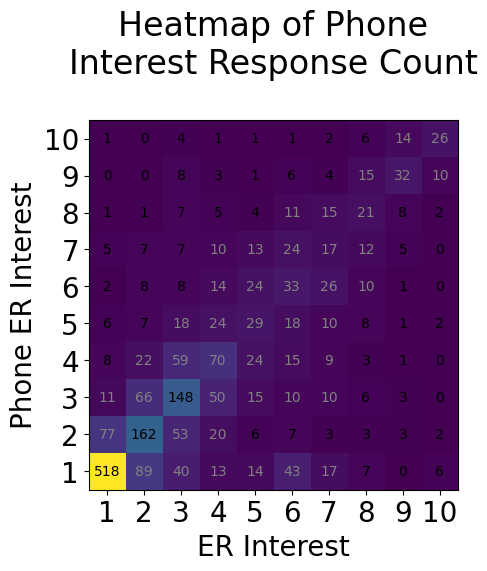

In [95]:
def local():
    df = emotions_df.copy()

    df = df[~df["ER Interest"].isna()]
    df = df[~df["Phone ER Interest"].isna()]

    heatmap = np.histogram2d(df["ER Interest"], df["Phone ER Interest"], bins=[1,2,3,4,5,6,7,8,9,10,11])[0]

    extent = (1, 11, 1, 11)

    plt.title("Heatmap of Phone\nInterest Response Count\n")
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            plt.gca().text(1.5+i, 1.5+j, str(int(heatmap[i, j])), ha="center", va="center", color= "gray" if heatmap[i, j] >= 9 and heatmap[i, j] <= 100 else "black", fontdict={"size":10})
    plt.yticks([x+0.5 for x in range(1,11)],[str(x) for x in range(1,11)])
    plt.xticks([x+0.5 for x in range(1,11)],[str(x) for x in range(1,11)])
    plt.ylabel("Phone ER Interest")
    plt.xlabel("ER Interest")
    plt.show()
local()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ER_Interest[2],1.644,0.207,1.247,2.026,0.003,0.002,3939.0,7311.0,1.0
ER_Interest[3],2.547,0.206,2.160,2.934,0.003,0.002,3798.0,6969.0,1.0
ER_Interest[4],3.285,0.230,2.864,3.725,0.004,0.003,3797.0,7034.0,1.0
ER_Interest[5],4.047,0.271,3.540,4.554,0.004,0.003,4466.0,8058.0,1.0
ER_Interest[6],4.630,0.306,4.055,5.212,0.005,0.003,4543.0,7467.0,1.0
ER_Interest[7],4.561,0.311,3.973,5.145,0.005,0.003,4508.0,7762.0,1.0
ER_Interest[8],5.604,0.348,4.980,6.282,0.005,0.004,4888.0,8662.0,1.0
ER_Interest[9],5.921,0.656,4.641,7.135,0.010,0.007,4470.0,7301.0,1.0
ER_Interest[10],4.797,2.597,-0.330,9.326,0.050,0.036,3017.0,3848.0,1.0


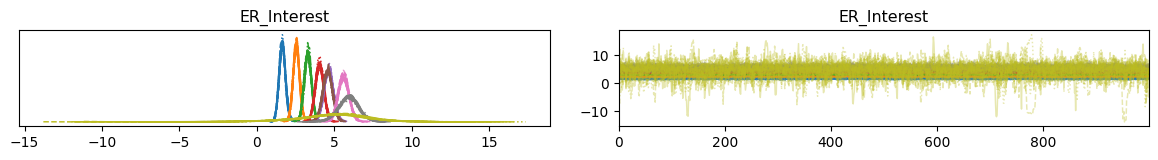

In [ ]:
def local():
    df = emotions_df.copy()

    df = df[~df["Response Time (min)"].isna()]
    df = df[~df["Phone ER Interest"].isna()]

    df["ER_Interest"] = pd.Categorical(df["ER Interest"].astype(int),ordered=True)
    df["Phone_ER_Interest"] = pd.Categorical(df["Phone ER Interest"].astype(int),ordered=True)

    df = df.reset_index(drop=True)

    md = bmb.Model("Phone_ER_Interest ~ 0 + ER_Interest + (ER_Interest|ParticipantId)", df, family="cumulative")
    mr = md.fit(tune=4000, target_accept=.95, cores=16)

    return mr
mr = local()

az.plot_trace(mr, var_names=["ER_Interest"], compact=True)
plt.tight_layout()

az.summary(mr, var_names=["ER_Interest"])

Below is the cumulative probability estimate

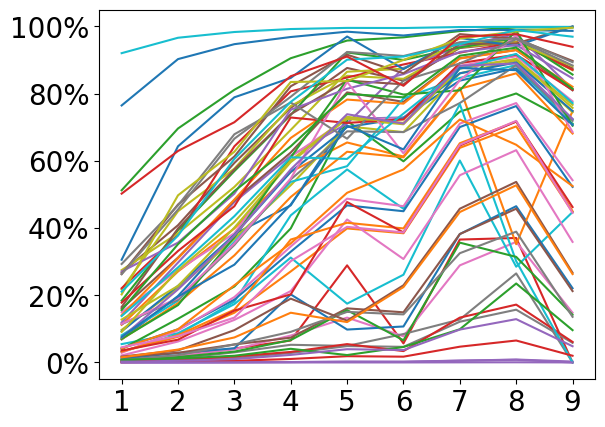

In [97]:
ger = mr.posterior["ER_Interest"].mean(axis=(0,1)).round(2)
pin = mr.posterior["1|ParticipantId"].mean(axis=(0,1)).round(2)
per = mr.posterior["ER_Interest|ParticipantId"].mean(axis=(0,1)).round(2)
data = np.array(ger+pin) + np.array(per)

plt.plot(np.exp(data)/(1+np.exp(data)))
plt.xticks([0,1,2,3,4,5,6,7,8],list(map(str,[1,2,3,4,5,6,7,8,9])))
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],["0%","20%","40%","60%","80%","100%"])
plt.show()

## Relationship between Phone ER interest and Day in Study

There does not appear to be any relationship between relative day in study and Phone ER Interest

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
RelDay[1],-0.726,0.279,-1.241,-0.197,0.003,0.002,9327.0,11089.0,1.0
RelDay[2],-0.740,0.312,-1.342,-0.164,0.003,0.002,10159.0,12249.0,1.0
RelDay[3],-0.373,0.255,-0.850,0.105,0.003,0.002,8780.0,12074.0,1.0
RelDay[4],-0.691,0.282,-1.234,-0.170,0.003,0.002,9842.0,12340.0,1.0
RelDay[5],-0.414,0.231,-0.852,0.015,0.003,0.002,8415.0,10689.0,1.0
RelDay[6],-0.130,0.248,-0.601,0.325,0.003,0.002,9377.0,11954.0,1.0
RelDay[7],-0.344,0.331,-0.979,0.266,0.003,0.002,9454.0,11988.0,1.0
RelDay[8],-0.595,0.367,-1.289,0.077,0.004,0.003,8931.0,12474.0,1.0
RelDay[9],-0.147,0.310,-0.749,0.428,0.003,0.002,10847.0,12034.0,1.0
RelDay[10],-0.287,0.359,-0.945,0.400,0.003,0.002,12282.0,12691.0,1.0


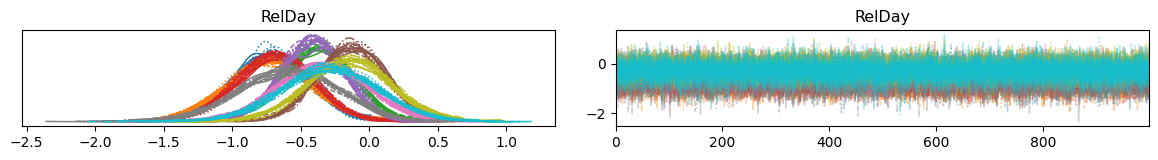

In [ ]:
def local():
    df = emotions_df.copy()

    df = df[~df["Phone ER Interest"].isna()]
    df = df[~df["RelDay"].isna()]

    df["Phone_ER_Interest"] = pd.Categorical(df["Phone ER Interest"].astype(int),ordered=True)
    df["RelDay"] = pd.Categorical(df["RelDay"].astype(int),ordered=True)

    df = df.reset_index(drop=True)

    md = bmb.Model("Phone_ER_Interest ~ 0 + RelDay + (RelDay|ParticipantId)", df, family="cumulative")
    mr = md.fit(tune=4000, target_accept=.95, cores=16)

    return mr
mr = local()

az.plot_trace(mr, var_names=["RelDay"], compact=True)
plt.tight_layout()

az.summary(mr, var_names=["RelDay"])

In [30]:
print(emotions_df.shape)
print(emotions_df[emotions_df["RelDay"]<=7].shape)

(3650, 25)
(2799, 25)


# Moderate Turnover In All 1s

The number of participants who report all 1 is about half as big as the total number of participants who report all 1. This suggests that half of the all 1 reporters change each day.

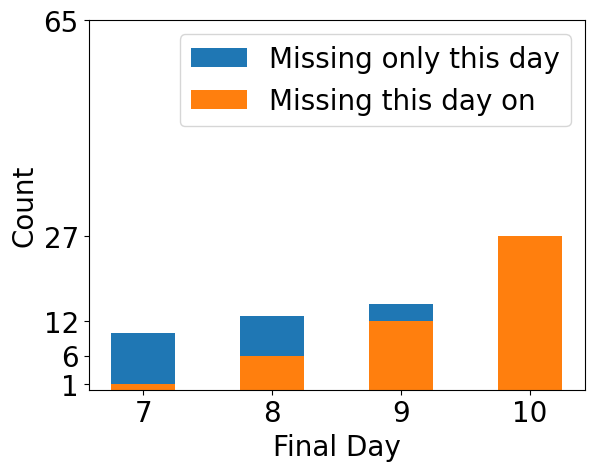

In [16]:
def local():
    df = emotions_df.copy()
    df = df[df["State Anxiety"]!= 1]
    
    counts1 = df.groupby("ParticipantId")["RelDay"].max().value_counts()
    counts2 = df.drop_duplicates(["RelDay","ParticipantId"])["RelDay"].value_counts()
    X  = [7,8,9,10]
    Y1 = [counts1[x-1] for x in X]
    Y2 = [65-counts2[x] for x in X]
    
    plt.bar(X, Y2, width=.5, label="Missing only this day")
    plt.bar(X, np.cumsum(Y1), width=.5, label="Missing this day on")
    #plt.bar([6.25, 8.25, 10.25, 12.25], Y2, width=.5, label="Missing on this day")
    plt.yticks([1,6,12,27,65])
    plt.legend()
    plt.ylabel("Count")
    plt.xlabel("Final Day")

    return 
local()

In [ ]:
def local():
    df = emotions_df.copy()
    df = df[df["State Anxiety"]!= 1]
    
    df = df.groupby("ParticipantId")["RelDay"].max().reset_index()

    df = df.rename(columns={"RelDay":"Last Day With Anxiety > 1"})

    return df[df["Last Day With Anxiety > 1"] <= 8 ]
local()


,ParticipantId,Last Day With Anxiety > 1
8,423,8.0
11,430,7.0
14,433,8.0
17,437,8.0
20,441,7.0
21,442,8.0
24,445,7.0
25,446,8.0
35,458,7.0
45,471,6.0


In [28]:
def local():
    drop = emotions_df.copy()
    keep = emotions_df.copy()
    
    drop = drop[drop["State Anxiety"]!= 1]
    drop = drop.groupby("ParticipantId")["RelDay"].max().reset_index()
    drop = drop.rename(columns={"RelDay":"Last Day With Anxiety > 1"})
    drop = drop[drop["Last Day With Anxiety > 1"] <= 8 ]

    for pid,day in drop.itertuples(index=False):
        is_not_pid = keep["ParticipantId"] != pid
        is_lt_day  = keep["RelDay"] < day
        keep = keep[is_not_pid | is_lt_day]

    return keep

keep_df = local()

dropped_rows = emotions_df.shape[0]-keep_df.shape[0]
print(f"Dropped {dropped_rows} rows")


Dropped 170 rows


## Relationship Between Response Time and Phone ER Interest

There is no relationship between response time and interest

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Response_Time,0.499,0.314,-0.090,1.084,0.003,0.002,11448.0,11445.0,1.0
Response_Time2,-0.187,0.113,-0.402,0.021,0.001,0.001,12763.0,11557.0,1.0


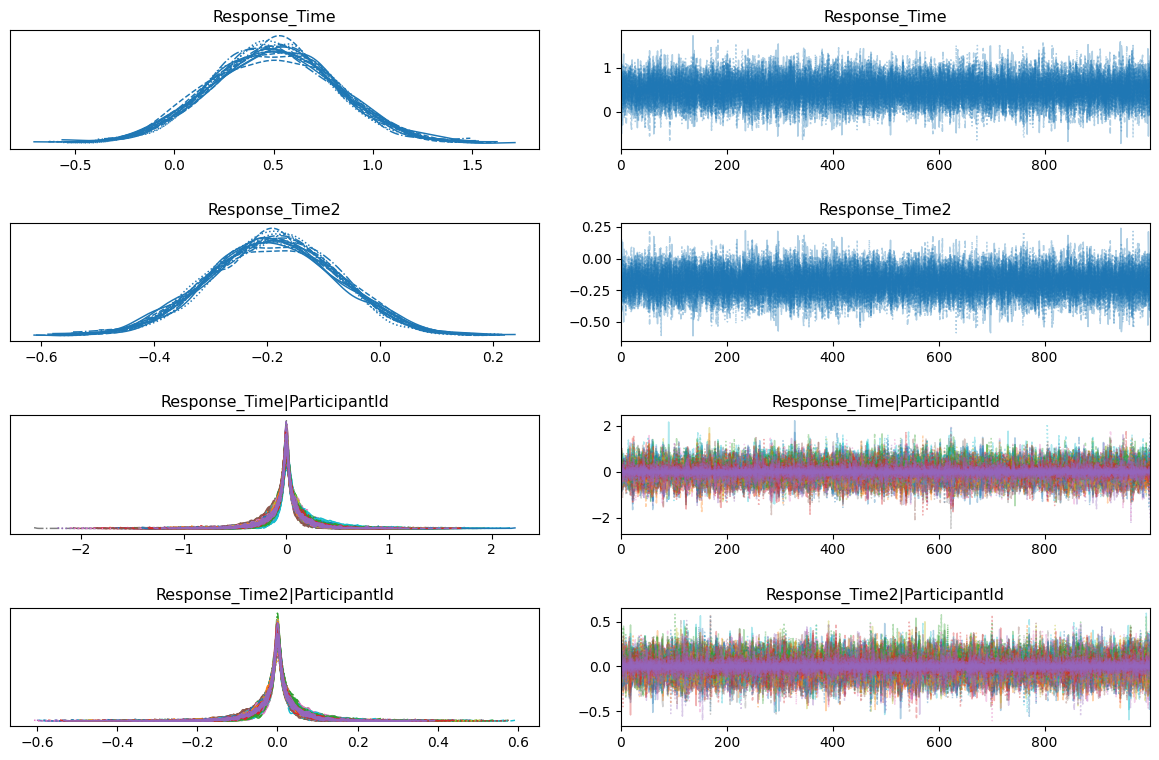

In [33]:
def local():
    import bambi as bmb
    import arviz as az
    from scipy import stats

    df = emotions_df.copy()

    df = df[~df["Response Time (min)"].isna()]
    df = df[~df["Phone ER Interest"].isna()]
    df = df[df["Response Time (min)"]<20]

    df["Phone_ER_Interest"] = pd.Categorical(df["Phone ER Interest"].astype(int),ordered=True)
    df["Response_Time"] = np.log(1+df["Response Time (min)"])
    df["Response_Time2"] = np.log(1+df["Response Time (min)"])**2

    md = bmb.Model("Phone_ER_Interest ~ Response_Time + Response_Time2 + (Response_Time+Response_Time2|ParticipantId)", df, family="cumulative")
    mr = md.fit(tune=4000, target_accept=.95, cores=16)

    return mr
#mr = local()

az.plot_trace(mr, var_names=["Response_Time", "Response_Time2","Response_Time|ParticipantId", "Response_Time2|ParticipantId"], compact=True)
plt.tight_layout()
az.summary(mr, var_names=["Response_Time", "Response_Time2"])

In [182]:
emotions_df["Response Time (min)"].mean()

8.267931853475837